In [1]:
%pip install torch torchvision tfrecord numpy matplotlib segmentation_models_pytorch

Note: you may need to restart the kernel to use updated packages.


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, IterableDataset
from tfrecord.reader import tfrecord_loader
import numpy as np
from glob import glob
import itertools
import matplotlib.pyplot as plt
from datetime import datetime
# import segmentation_models_pytorch as smp

from wildfire import *

SyntaxError: invalid syntax (wildfire.py, line 180)

## Validation

In [ ]:
print(IMG_SHAPE)

In [ ]:
display_tfrecord("archive/next_day_wildfire_spread_train_00.tfrecord", n=30)

In [ ]:
model_path = 'models/best_SFB0/SegFormerB0.pth'
model = SegFormerB0().to(DEVICE)
# model = smp.Unet(
#     encoder_name="resnet18",
#     encoder_weights=None,        # Important: avoid overwriting with pretrained weights
#     in_channels=12,
#     classes=2
# ).to(DEVICE)

model.load_state_dict(torch.load(model_path, map_location=DEVICE))
num_samples = 30
threshold=0.26

# model = smp.Unet(encoder_name="resnet18", encoder_weights="imagenet", in_channels=12, classes=2).to(DEVICE)
###########
model.eval()

# Load validation data
val_paths = sorted(glob("archive/next_day_wildfire_spread_train_*.tfrecord"))
val_loader = DataLoader(WildfireTFRecordDataset(val_paths), batch_size=1)

# Get samples
samples = list(itertools.islice(val_loader, num_samples))

firemask_cmap = ListedColormap(['dimgray', 'lightgray', 'red'])
firemask_norm = BoundaryNorm([-1.5, -0.5, 0.5, 1.5], firemask_cmap.N)

for i, (x, y_true) in enumerate(samples):
    # Get prediction
    with torch.no_grad():
        x = x.to(DEVICE)
        logits = model(x)
        probs = torch.softmax(logits, dim=1)
        pos_probs = probs[:, 1, :, :]
        y_pred = (pos_probs >= threshold).long()
        # y_pred = torch.argmax(logits, dim=1)
    y_true = y_true.cpu().numpy()[0]
    y_pred = y_pred.cpu().numpy()[0]
    print(y_pred)
    if any(p==1 for p in y_pred.flatten()) :
    
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6,3))
        
        # Plot ground truth
        ax1.imshow(y_true, cmap=firemask_cmap, norm=firemask_norm)
        ax1.set_title('Ground Truth Fire Mask')
        ax1.axis('off')
        
        # Plot prediction
        ax2.imshow(y_pred, cmap=firemask_cmap, norm=firemask_norm)
        ax2.set_title('Predicted Fire Mask')
        ax2.axis('off')
        
        plt.suptitle(f'Sample {i+1}')
        plt.tight_layout()
        plt.show()
    else:
        pass

In [ ]:
model = smp.Unet(encoder_name="resnet18", encoder_weights="imagenet", in_channels=12, classes=2).to(DEVICE)
data_paths = sorted(glob("archive/next_day_wildfire_spread_eval_*.tfrecord"))
data_loader = DataLoader(WildfireTFRecordDataset(val_paths), batch_size=8)
####
test_loss_avg, auc_pr, precision, recall, f1_score = get_statistics(model, data_loader, torch.tensor(np.array([0.1, 0.9]), dtype=torch.float32, device=DEVICE), maxsamples=50)
print(f"test_loss_avg: {test_loss_avg}")
print(f"auc_pr: {auc_pr}")
print(f"precision: {precision}")
print(f"recall: {recall}")
print(f"f1_score: {f1_score}")

In [ ]:
import tqdm

model = smp.Unet(
    encoder_name="resnet18",
    encoder_weights="imagenet",
    in_channels=12,
    classes=2  # assumes softmax over fire/no-fire
).to(DEVICE)

train_paths = sorted(glob("archive/next_day_wildfire_spread_train_*.tfrecord"))
eval_paths = sorted(glob("archive/next_day_wildfire_spread_eval_*.tfrecord"))

train_loader = DataLoader(WildfireTFRecordDataset(train_paths), batch_size=8)
eval_loader = DataLoader(WildfireTFRecordDataset(eval_paths), batch_size=8)

class_weights = torch.tensor([0.33, 0.67], dtype=torch.float32, device=DEVICE)  # adjust if needed
loss_fn = nn.CrossEntropyLoss(weight=class_weights, ignore_index=255)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 1  # adjust as needed

model.train()
for epoch in range(num_epochs):
    print(f"Beginning Epoch {epoch + 1}")
    epoch_loss = 0.0
    ct = 0
    for x_batch, y_batch in tqdm.tqdm(train_loader):
        ct += x_batch.shape[0]
        x_batch = x_batch.to(DEVICE)
        y_batch = y_batch.to(DEVICE)

        optimizer.zero_grad()
        logits = model(x_batch)
        loss = loss_fn(logits, y_batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"[Epoch {epoch+1}] Train Loss: {epoch_loss}")

save_path = "models/finetuned_unet_smp.pth"
torch.save(model.state_dict(), save_path)
print(f"Model saved to {save_path}")



In [ ]:
# eval
model.eval()
test_loss_avg, auc_pr, precision, recall, f1_score = get_statistics(
    model,
    eval_loader,
    class_weights,
    maxsamples=150
)

print(f"\ntest_loss_avg: {test_loss_avg}")
print(f"auc_pr: {auc_pr}")
print(f"precision: {precision}")
print(f"recall: {recall}")
print(f"f1_score: {f1_score}")

## Feature Analysis

In [ ]:
def get_model(model_type):
    if model_type == 'UNet' :
        model_path = 'models/best_UNet/UNet.pth'
        model = UNet().to(DEVICE)
    elif model_type == 'SegFormerB0' :
        model_path = 'models/best_SFB0/SegFormerB0.pth'
        model = SegFormerB0().to(DEVICE)
    elif model_type == 'SegFormerB1' :
        model_path = 'models/best_SFB1/SegFormerB1.pth'
        model = SegFormerB0().to(DEVICE)
    else :
        raise ValueError(f"model type {model_type} does not exist")
    
    model.load_state_dict(torch.load(model_path, map_location=DEVICE))
    return model

Data Sample 1:


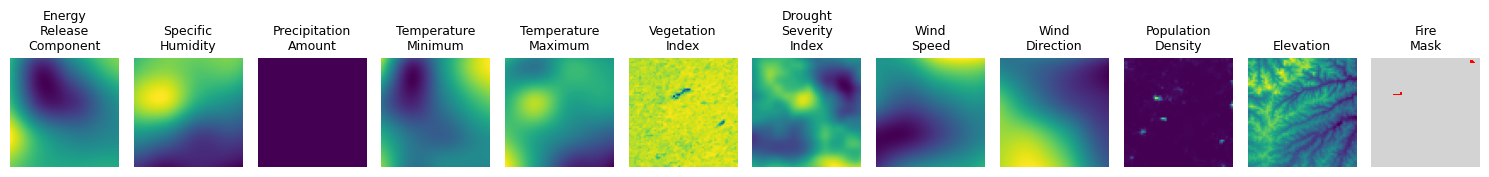

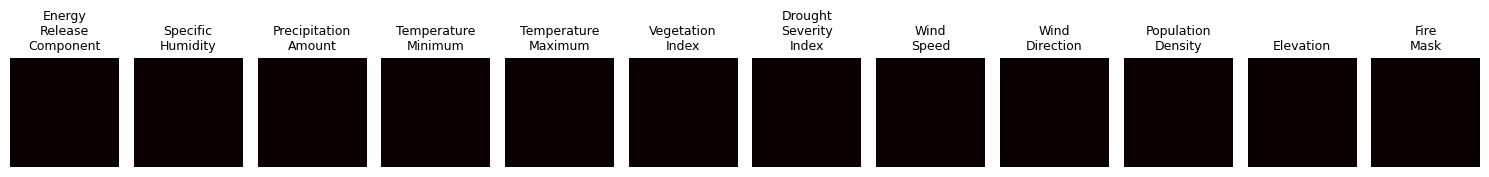

max prob: 0.5012593269348145


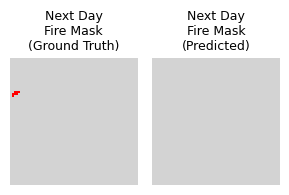

Data Sample 2:


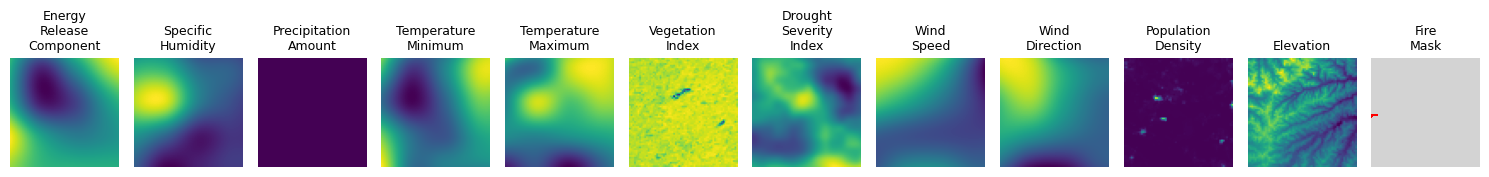

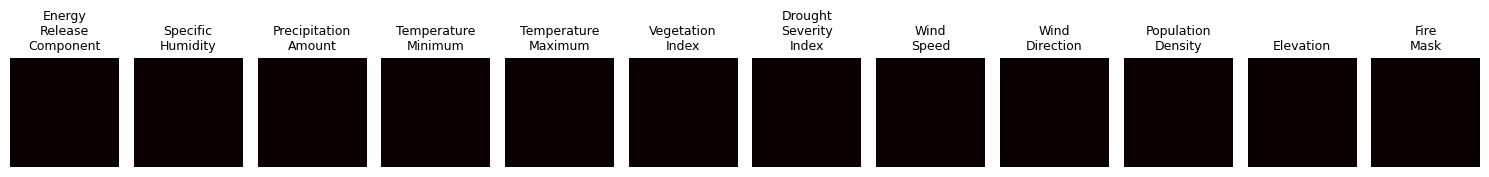

max prob: 0.5012357234954834


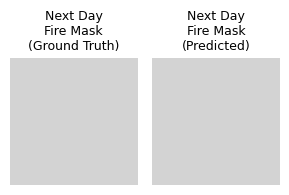

Data Sample 3:


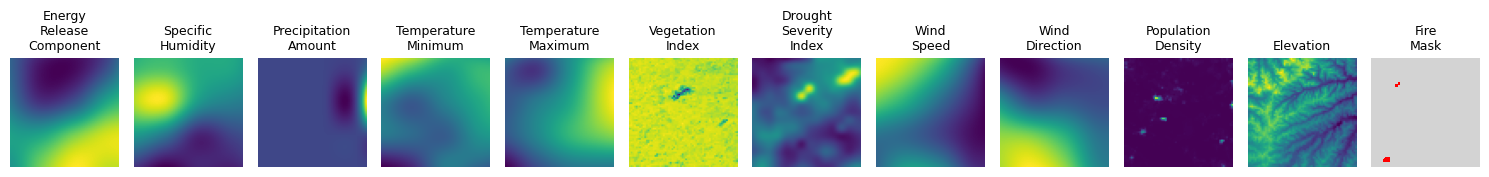

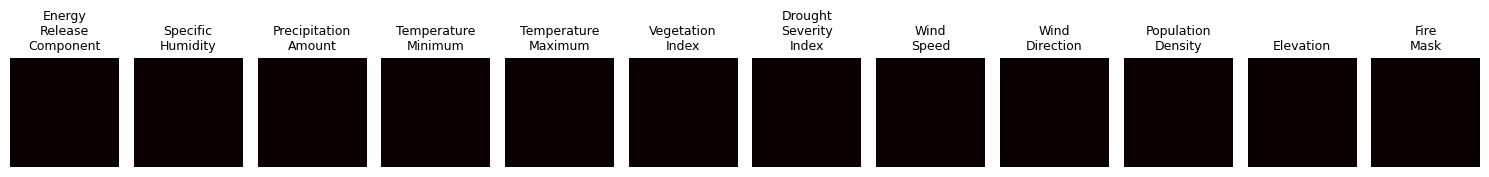

max prob: 0.5009528398513794


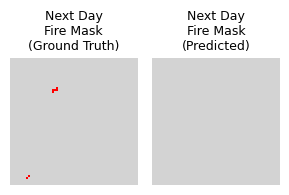

Data Sample 4:


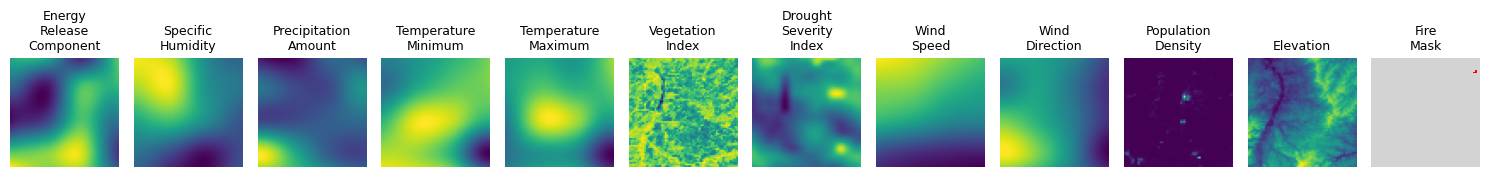

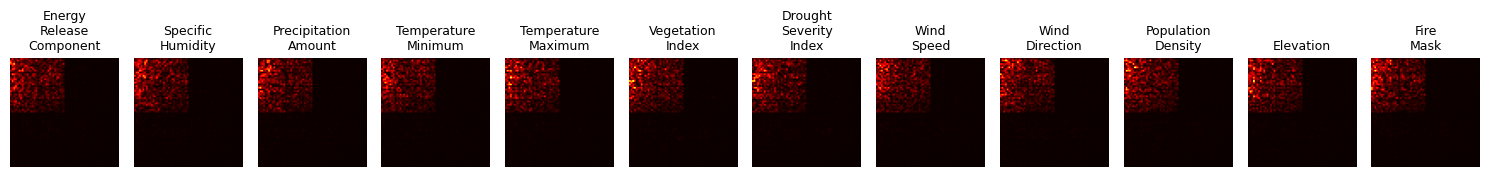

max prob: 0.5022786259651184


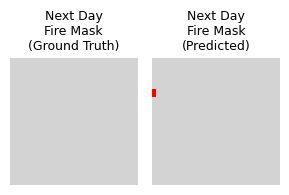

Data Sample 5:


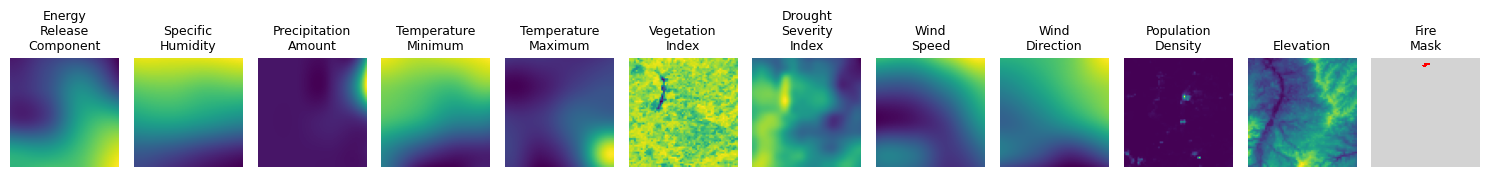

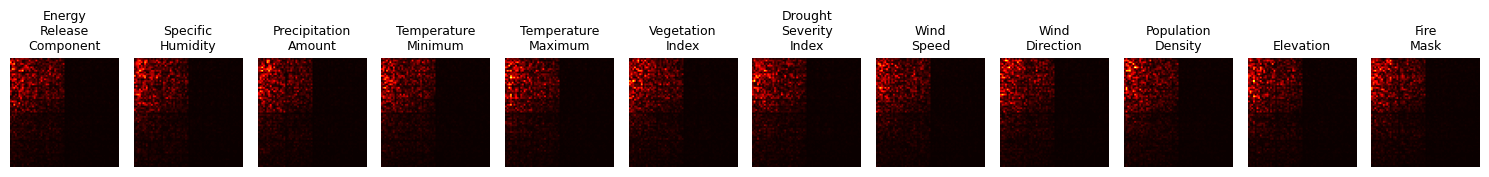

max prob: 0.5031536221504211


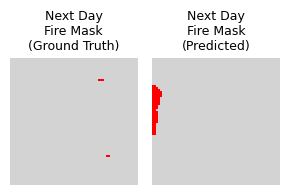

Data Sample 6:


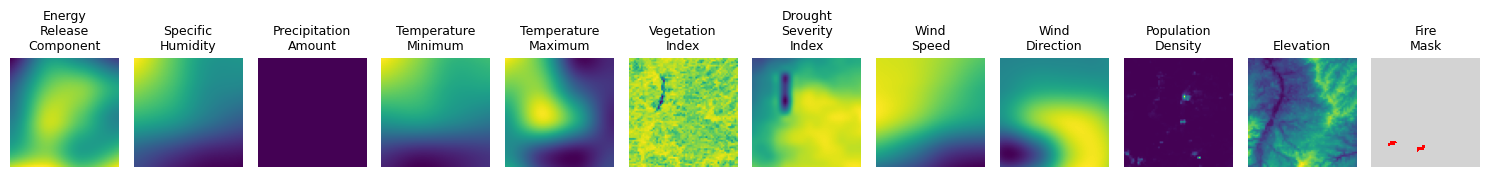

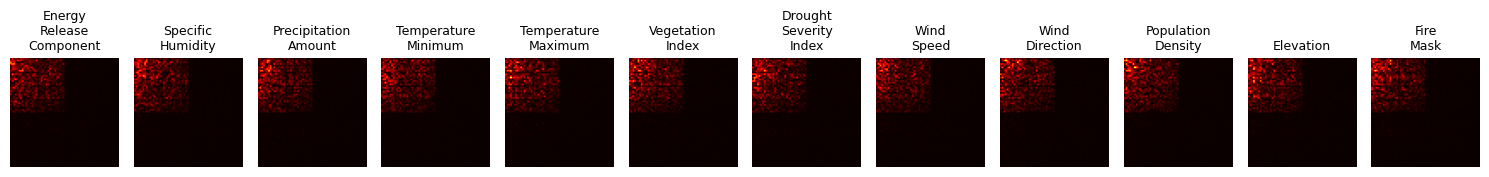

max prob: 0.5032376050949097


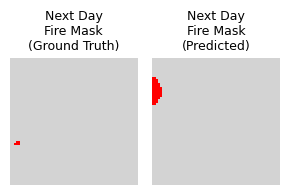

Data Sample 7:


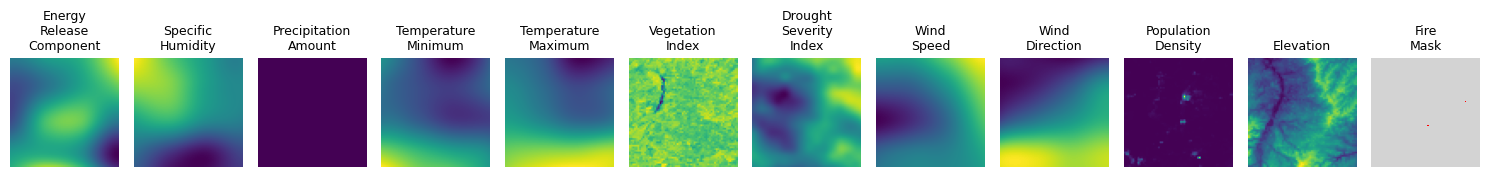

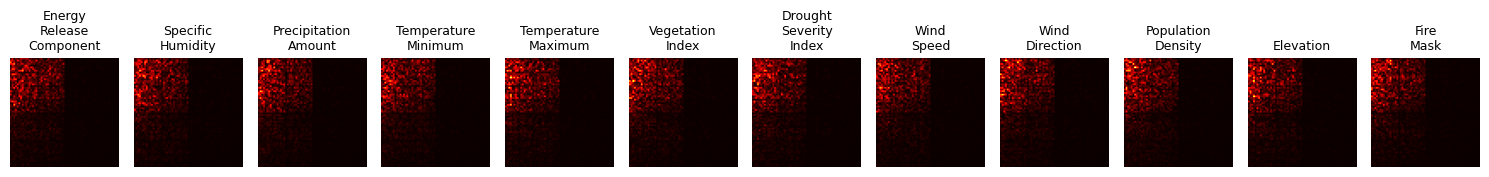

max prob: 0.5041959285736084


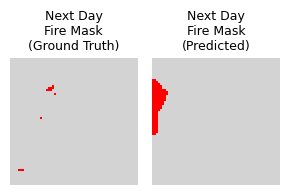

Data Sample 8:


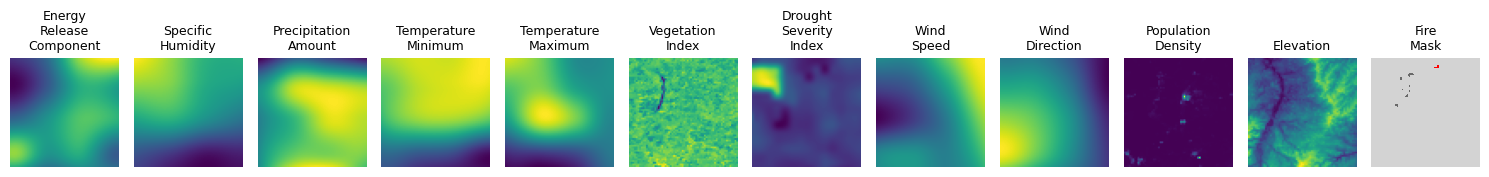

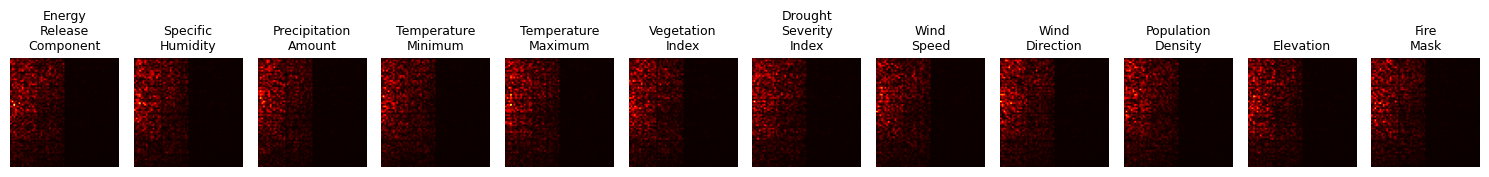

max prob: 0.5031285881996155


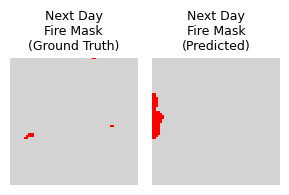

Data Sample 9:


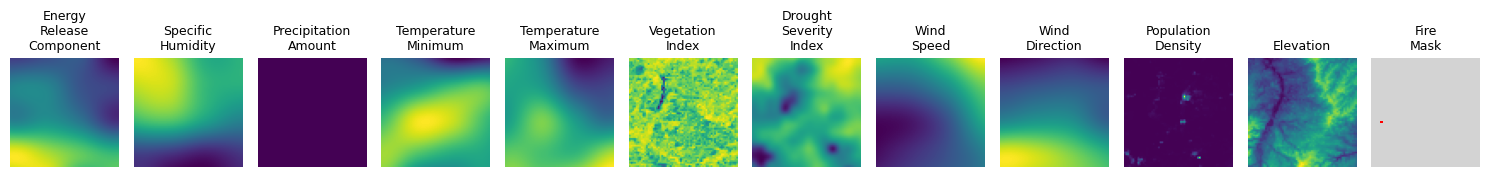

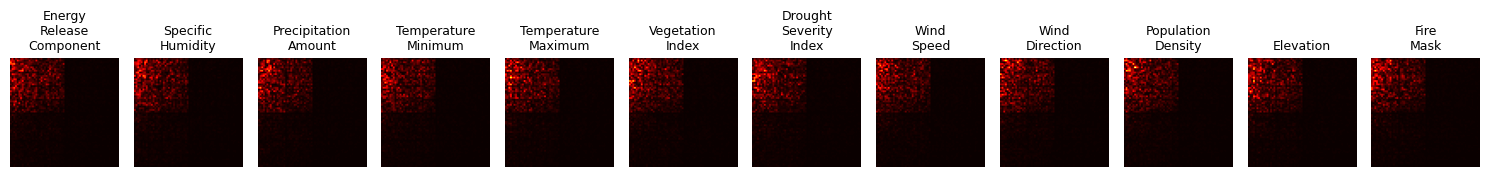

max prob: 0.5022587180137634


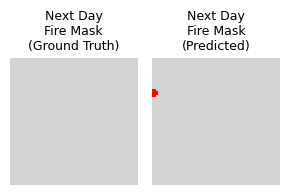

Data Sample 10:


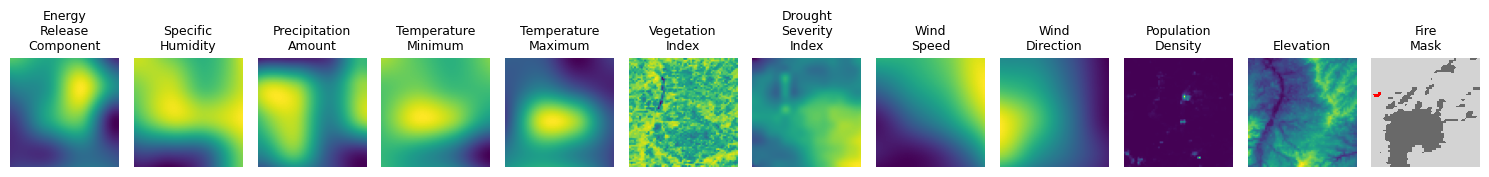

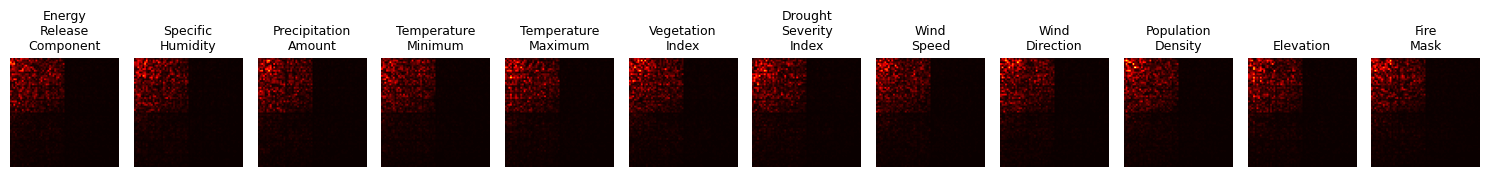

max prob: 0.5051512122154236


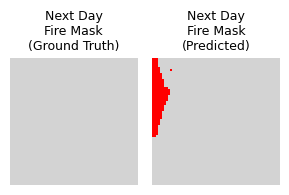

In [29]:
from wildfire import *
model_type = 'SegFormerB0'

num_iters = 10
n_samples=75
noise_std=0.2
threshold=0.502

####

model = get_model(model_type)
val_paths = sorted(glob("archive/next_day_wildfire_spread_train_*.tfrecord"))
val_loader = DataLoader(WildfireTFRecordDataset(val_paths), batch_size=1)
data = iter(val_loader)
for i in range(num_iters) :
    print(f"Data Sample {i+1}:")
    x, y = next(data)
    plot_saliency_etal(model, x, y, n_samples=n_samples, noise_std=noise_std, threshold=threshold)

Data Sample 0:


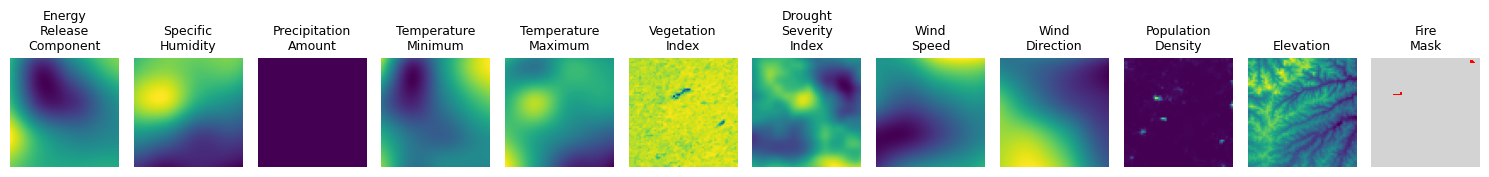

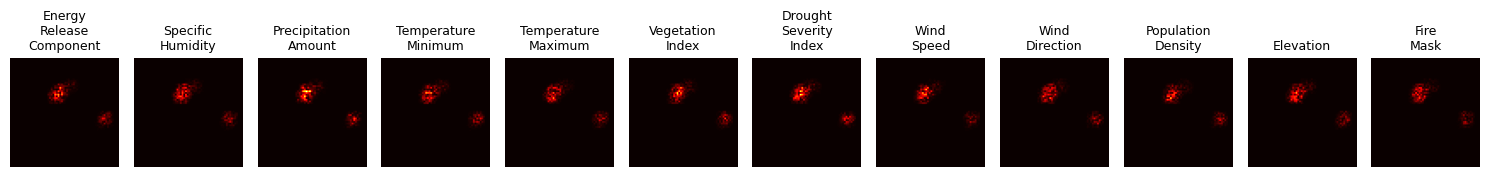

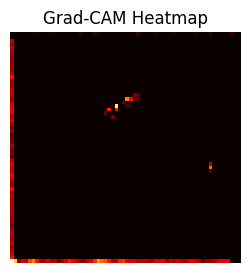

max prob: 1.0
max prob in center: 0.9999715089797974


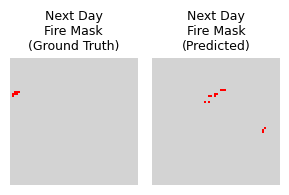

Data Sample 1:


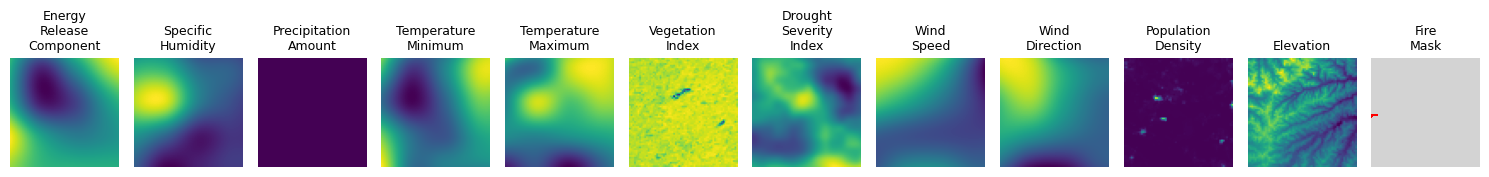

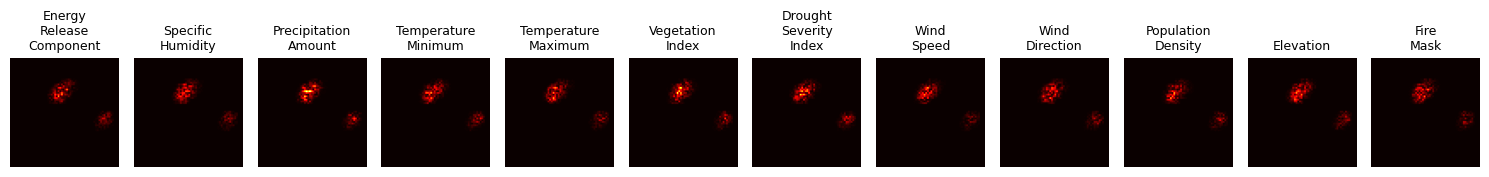

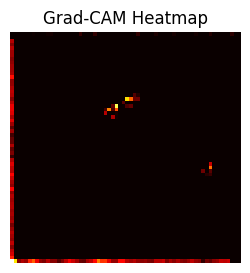

max prob: 1.0
max prob in center: 0.9999780654907227


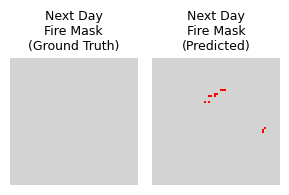

Data Sample 2:


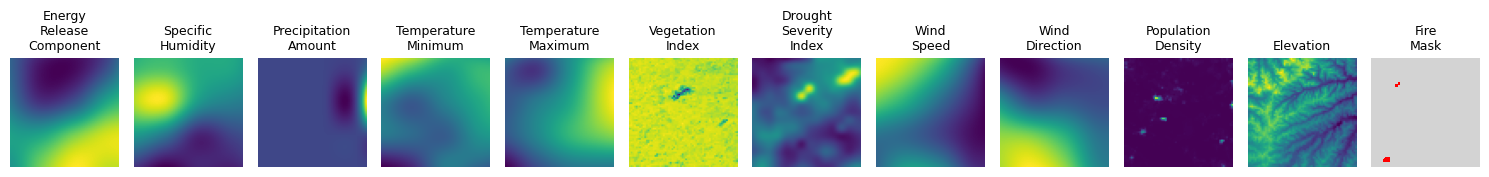

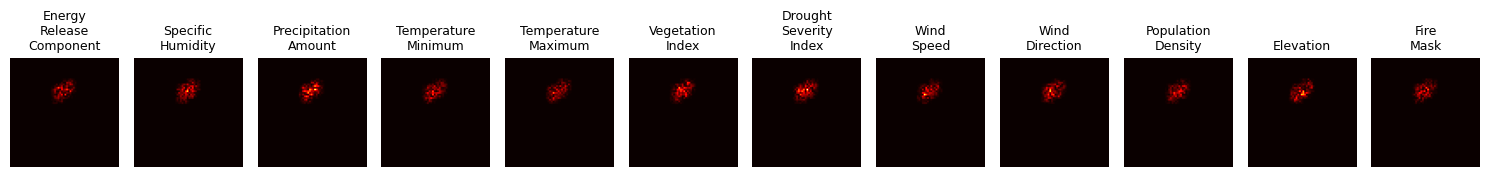

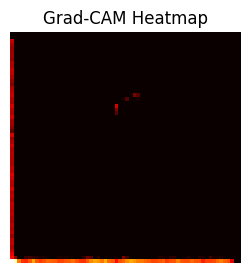

max prob: 1.0
max prob in center: 0.9999141693115234


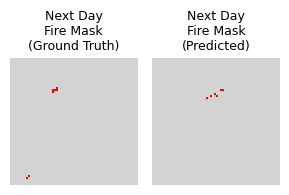

Data Sample 3:


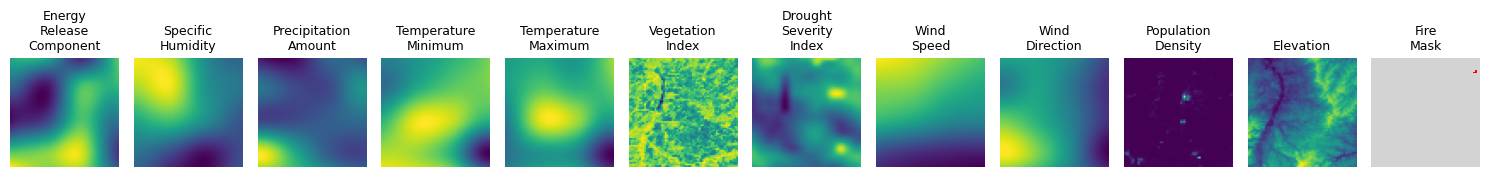

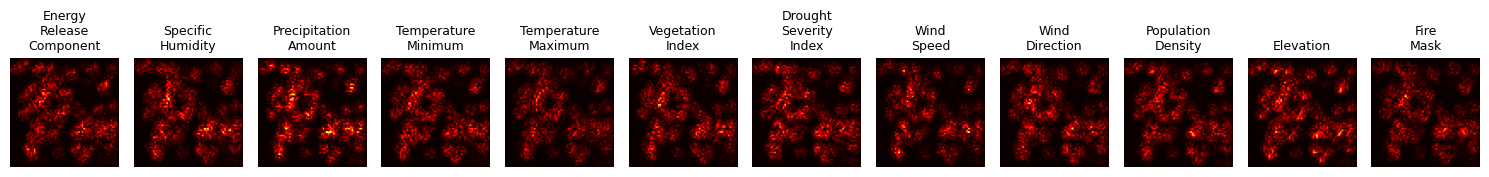

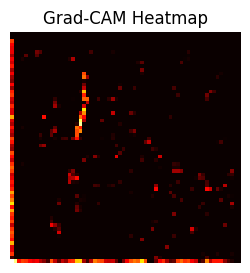

max prob: 1.0
max prob in center: 0.9999985694885254


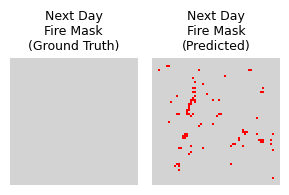

Data Sample 4:


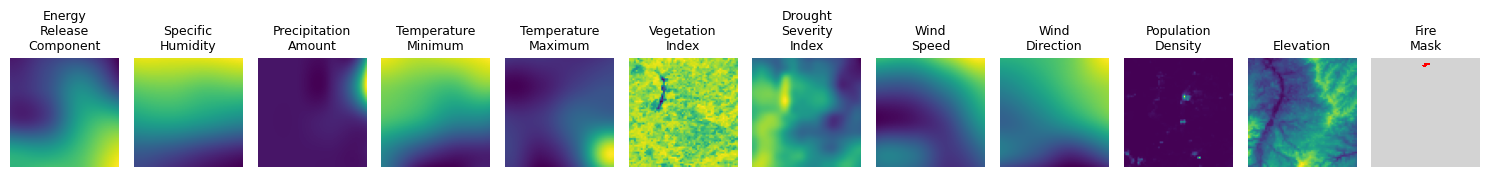

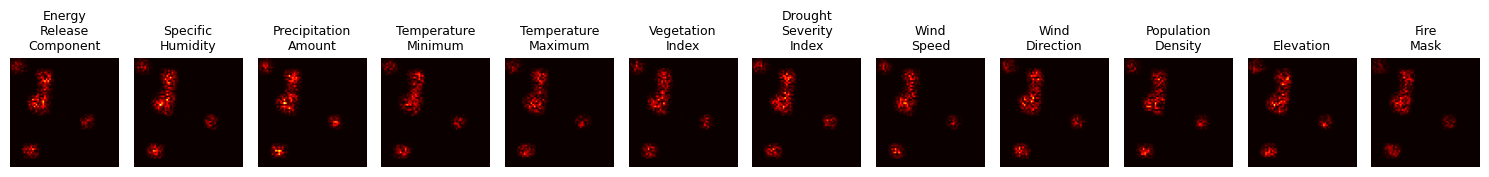

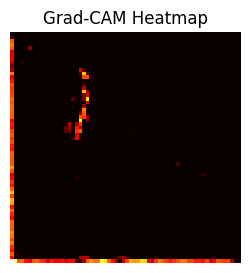

max prob: 1.0
max prob in center: 1.0


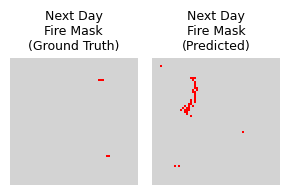

Data Sample 5:


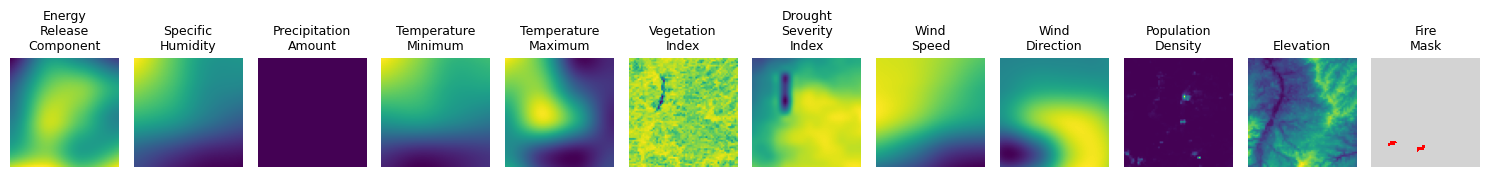

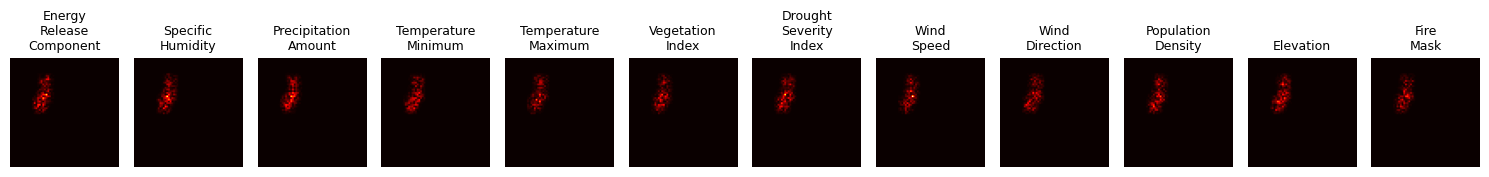

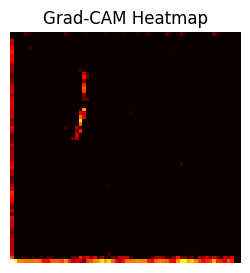

max prob: 1.0
max prob in center: 0.9999994039535522


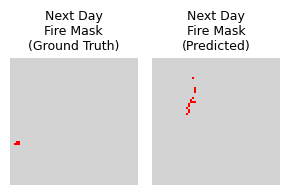

Data Sample 6:


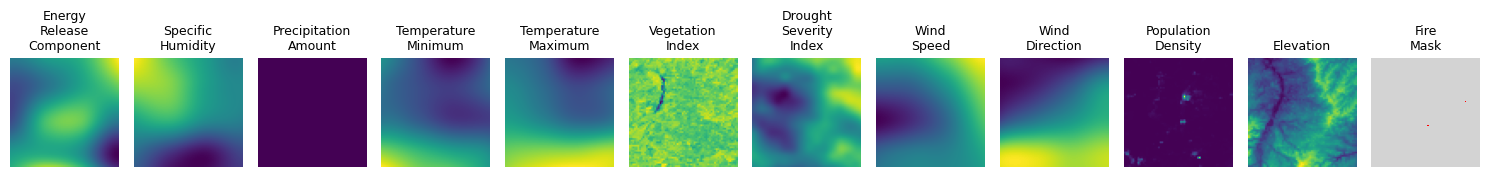

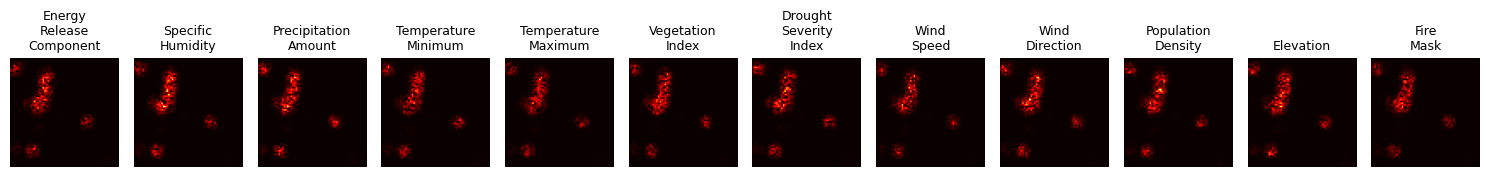

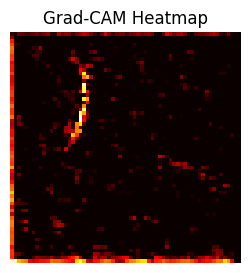

max prob: 1.0
max prob in center: 0.9999998807907104


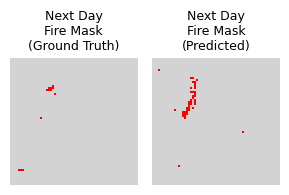

Data Sample 7:


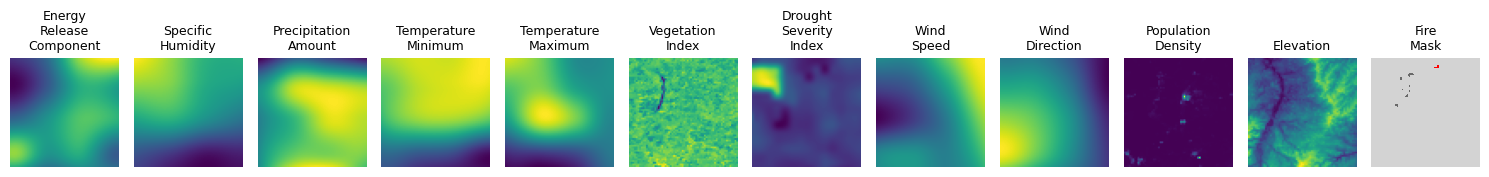

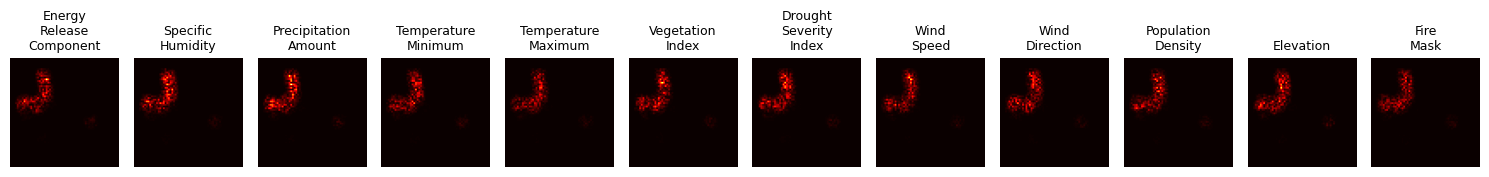

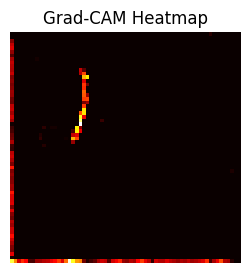

max prob: 1.0
max prob in center: 0.9999978542327881


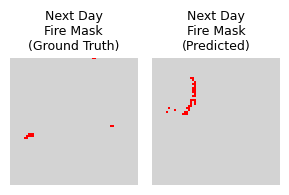

Data Sample 8:


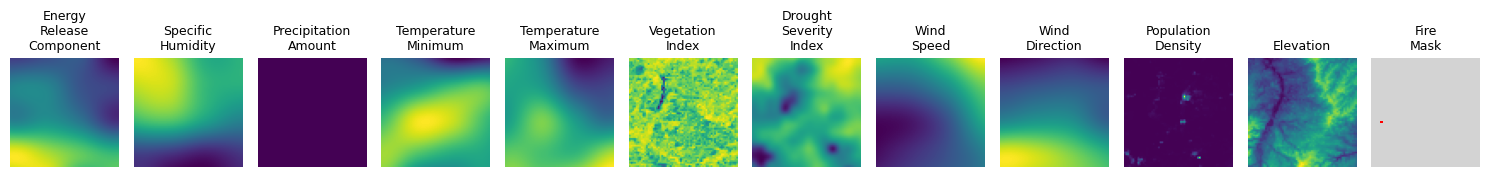

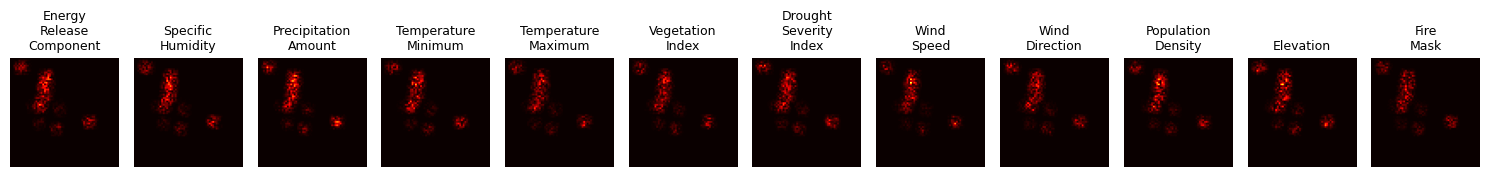

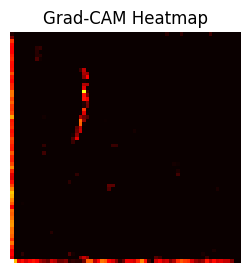

max prob: 1.0
max prob in center: 0.9999711513519287


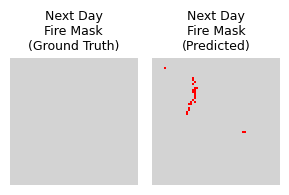

Data Sample 9:


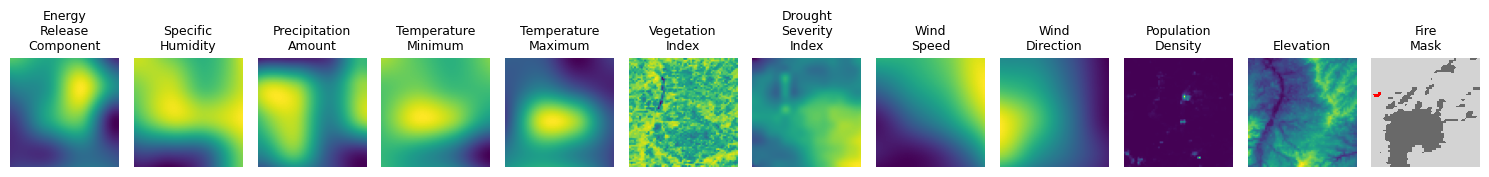

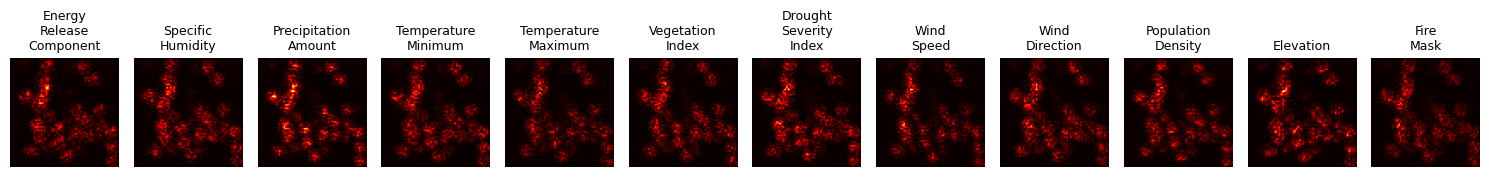

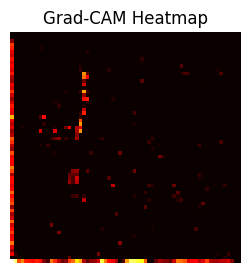

max prob: 1.0
max prob in center: 1.0


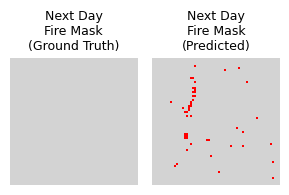

Data Sample 10:


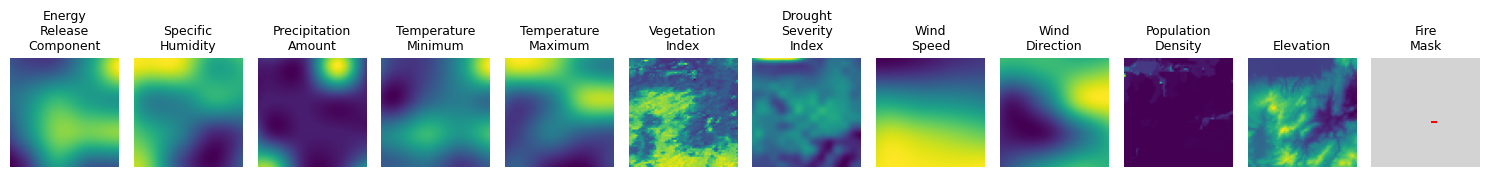

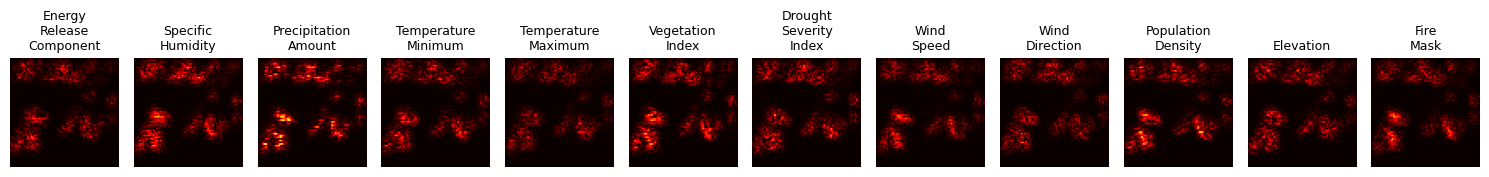

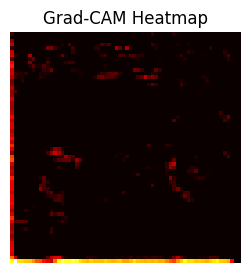

max prob: 1.0
max prob in center: 0.9999550580978394


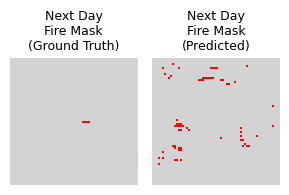

Data Sample 11:


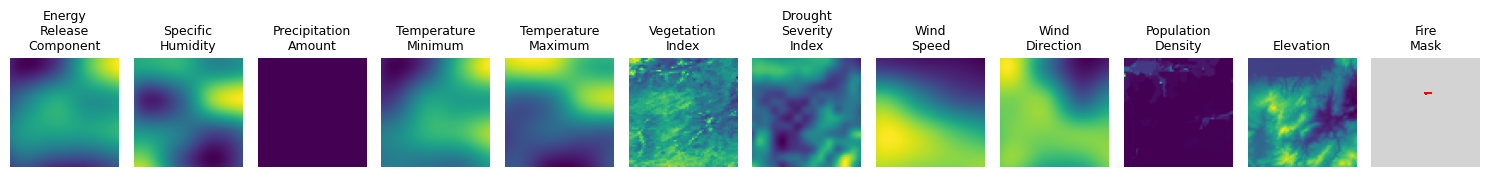

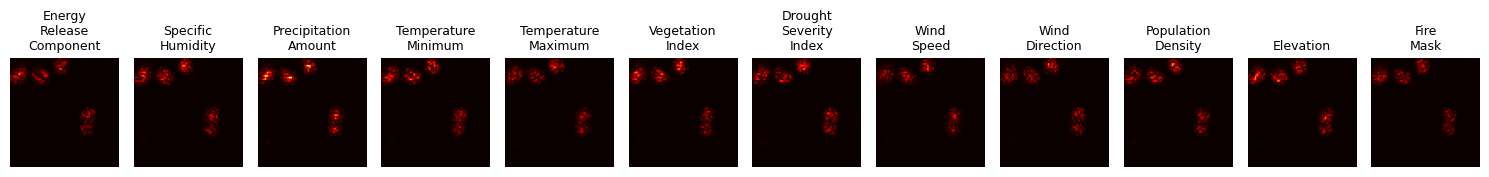

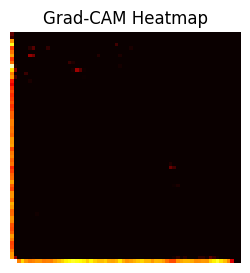

max prob: 1.0
max prob in center: 0.9998875856399536


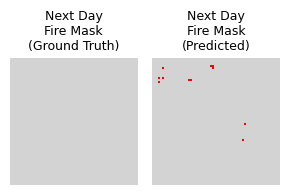

Data Sample 12:


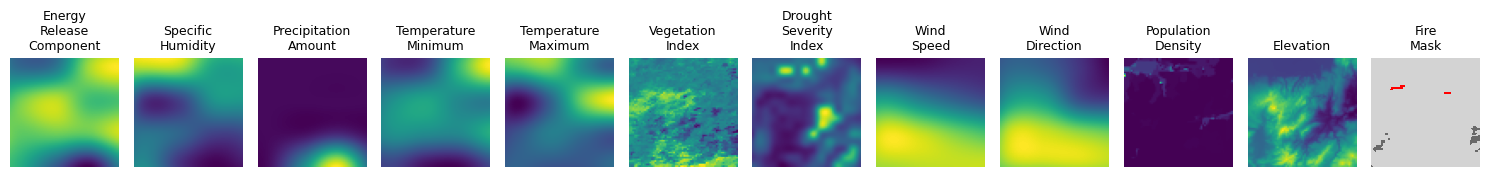

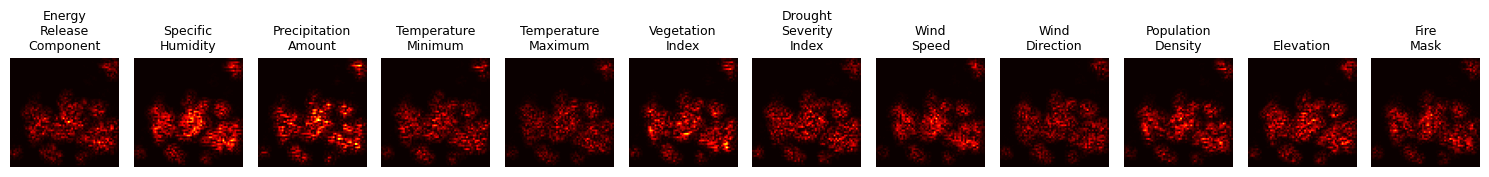

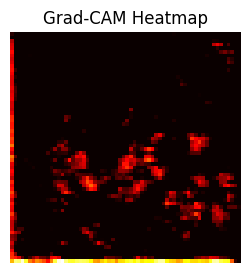

max prob: 1.0
max prob in center: 0.9999991655349731


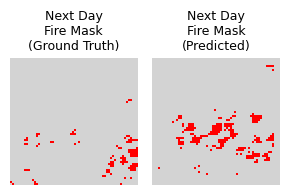

Data Sample 13:


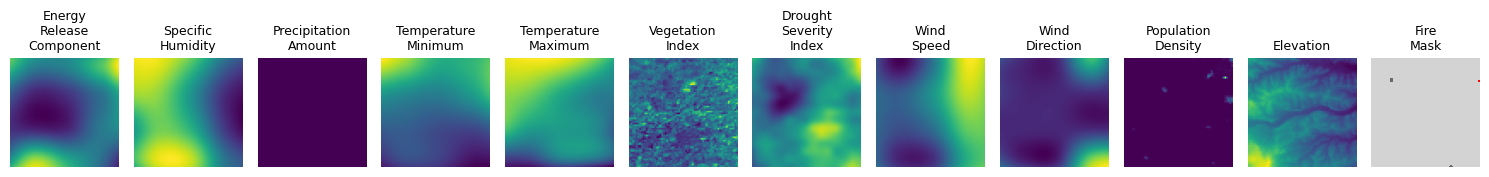

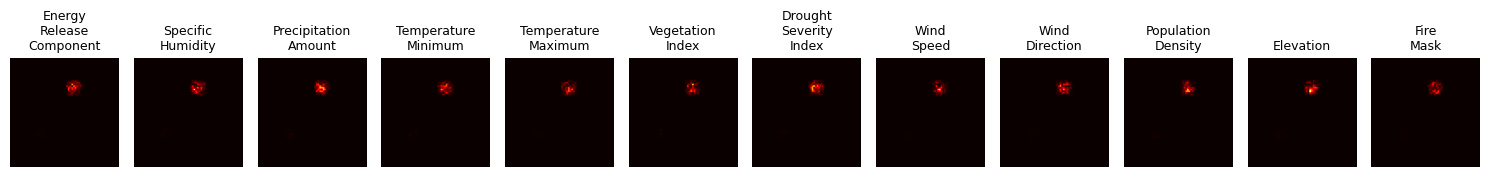

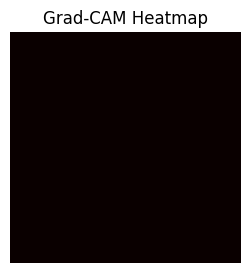

max prob: 0.9999973773956299
max prob in center: 0.9509642720222473


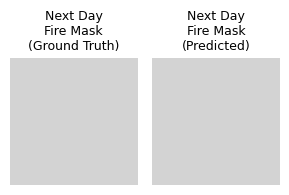

Data Sample 14:


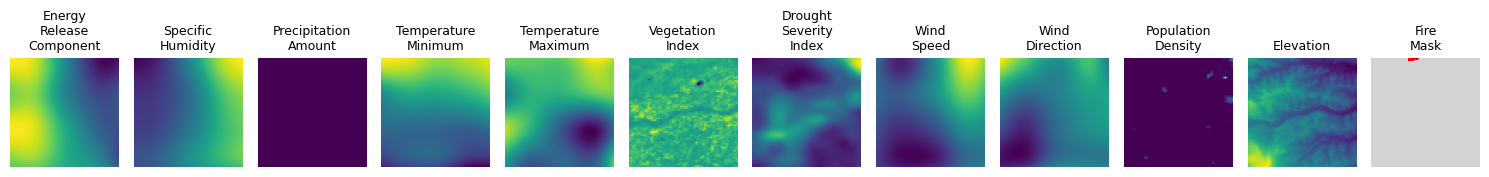

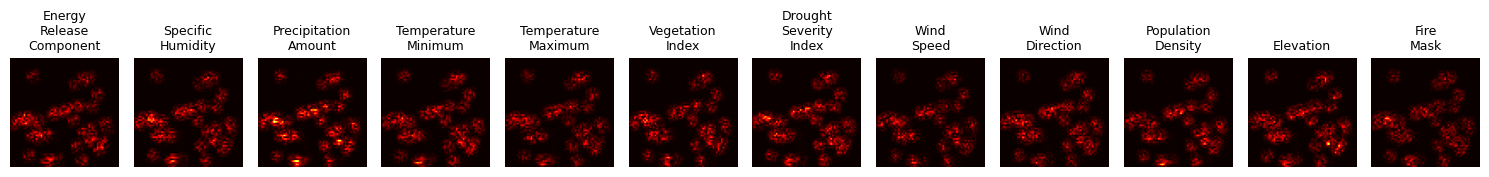

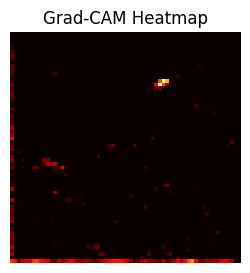

max prob: 1.0
max prob in center: 0.9999876022338867


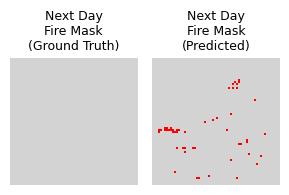

In [12]:
from wildfire import *

iters = 15
model_type = 'UNet'

####
torch.manual_seed(0)
np.random.seed(0)

val_paths = sorted(glob("archive/next_day_wildfire_spread_train_*.tfrecord"))
val_loader = DataLoader(WildfireTFRecordDataset(val_paths), batch_size=1)
data = iter(val_loader)
model = get_model(model_type)
target_layer = model.dec1[0]  # change based on your model structure

gradcam = GradCAM(model, target_layer)

analyzer = FeatureAnalyzer(
    model=model,
    gradcam_layer=model.dec1[0] if model_type=='UNet' else None,
    noise_std=0.2,
    n_samples=100,
    threshold=0.97,
    border_size=3,
    collapse=False
)

for i in range(iters) :
    x, y = next(data)
    print(f"Data Sample {i}:")
    analyzer.analyze(x, y)